In [1]:
#%%
%load_ext autoreload
%autoreload 2

#%%
import os
from os.path import join
import pandas as pd
from circuit_toolkit.plot_utils import saveallforms
import matplotlib.pyplot as plt
import seaborn as sns

#%%

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [ ]:
from itertools import product
import pandas as pd

def generate_test_prompts_collection_and_parsed_words():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words


prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
prompt_df["relation_str"] = prompt_df["relation"].apply(lambda x: "_".join(x))

In [ ]:
# Add spatial_relation_loose column based on Dx, Dy and prompt_id
def evaluate_spatial_relation_loose_vectorized(df, threshold = 8):
    """
    Evaluate spatial relationship with looser criteria based on Dx, Dy and prompt_id.
    This allows for more tolerance in position relative to the strict spatial_relationship column.
    """
    dx, dy = df['Dx'], df['Dy']
    prompt_id = df['prompt_id']
    
    # Initialize result array with False
    result = pd.Series(False, index=df.index)
    
    # Define looser thresholds (you can adjust these values)
    # Map prompt_ids to expected spatial relationships
    # This is a simplified mapping - you may need to adjust based on your actual prompt structure
    
    # "above"
    mask_above = (prompt_id % 8 == 0)
    result[mask_above] = dy[mask_above] < -threshold
    
    # "below" 
    mask_below = (prompt_id % 8 == 1)
    result[mask_below] = dy[mask_below] > threshold
    
    # "left"
    mask_left = (prompt_id % 8 == 2)
    result[mask_left] = dx[mask_left] < -threshold
    
    # "right"
    mask_right = (prompt_id % 8 == 3)
    result[mask_right] = dx[mask_right] > threshold
    
    # "above_left"
    mask_above_left = (prompt_id % 8 == 4)
    result[mask_above_left] = (dx[mask_above_left] < -threshold) & (dy[mask_above_left] < -threshold)
    
    # "above_right"
    mask_above_right = (prompt_id % 8 == 5)
    result[mask_above_right] = (dx[mask_above_right] > threshold) & (dy[mask_above_right] < -threshold)
    
    # "below_left"
    mask_below_left = (prompt_id % 8 == 6)
    result[mask_below_left] = (dx[mask_below_left] < -threshold) & (dy[mask_below_left] > threshold)
    
    # "below_right"
    mask_below_right = (prompt_id % 8 == 7)
    result[mask_below_right] = (dx[mask_below_right] > threshold) & (dy[mask_below_right] > threshold)
    
    return result.astype(bool)

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... True False True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold


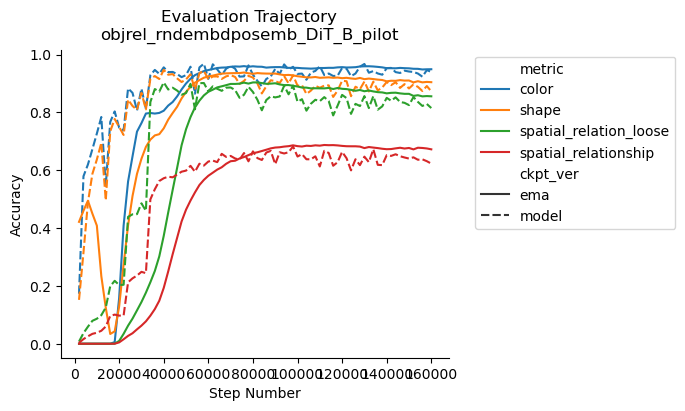

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold


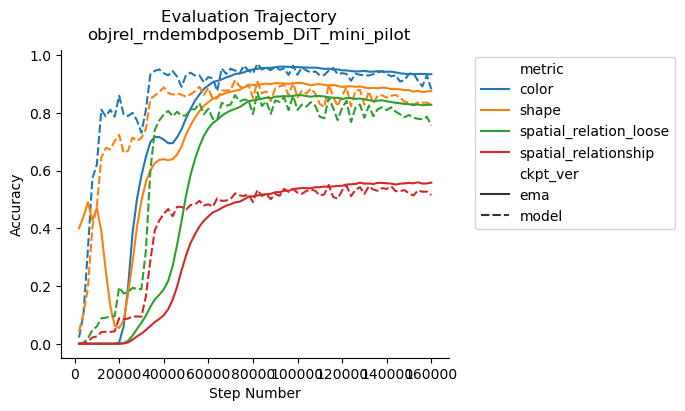

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold


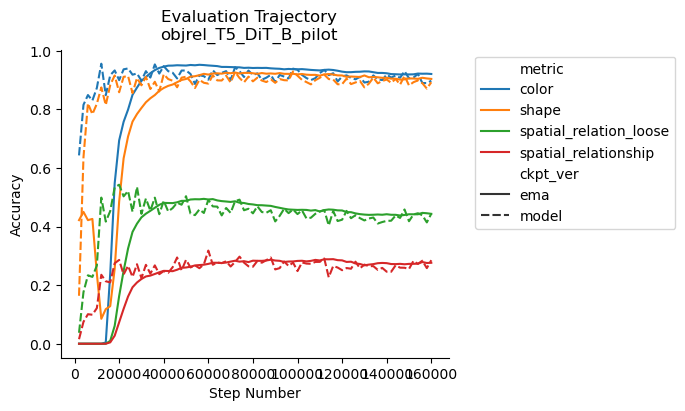

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold


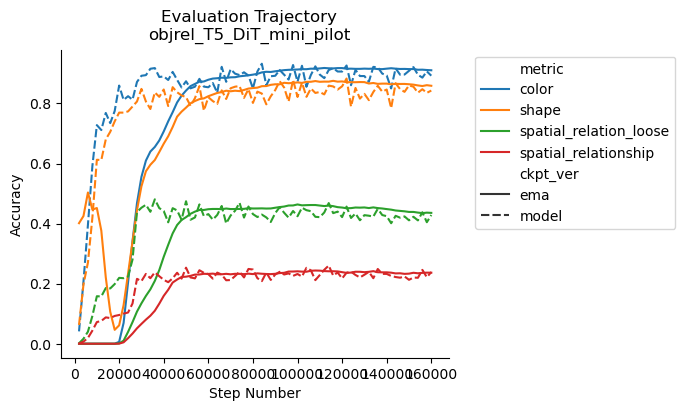

In [66]:

#%%
synopsis_dir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis"
os.makedirs(synopsis_dir, exist_ok=True)

#%%
for model_run_name in ["objrel_rndembdposemb_DiT_B_pilot", 
                        "objrel_rndembdposemb_DiT_mini_pilot", 
                        "objrel_T5_DiT_B_pilot", 
                        "objrel_T5_DiT_mini_pilot", 
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "large_scale_eval_posthoc")
    eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_train_traj_prompts.csv"))
    object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))
    eval_df_all_traj['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_df_all_traj, threshold = 8)
    eval_df_all_traj_syn = eval_df_all_traj.groupby(["step_num", "ckpt_ver"]).mean(numeric_only=True).reset_index()
    # eval_df_all_traj_syn.droplevel
    # 1) melt into long form
    df_long = eval_df_all_traj_syn.reset_index().melt(
        id_vars=["step_num", "ckpt_ver"],
        value_vars=["color", "shape", "spatial_relation_loose", "spatial_relationship"],
        var_name="metric",
        value_name="value",
    )
    # 2) make the combined label column
    df_long["legend_label"] = df_long["metric"] + " " + df_long["ckpt_ver"]
    # 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long,
        x="step_num",
        y="value",
        hue="metric",
        style="ckpt_ver",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name}")
    # saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    saveallforms(synopsis_dir, f"{model_run_name}_eval_train_dynamics_traj_syn")
    plt.show()

### Rerun eval for less stringent spatial relationship

In [4]:
eval_df_all_traj.shape

(1536000, 15)

In [6]:
eval_df_all_traj.tail()

,step_num,ckpt_ver,sample_id,prompt,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2
1535995,160000,model,95,blue circle is below and to the right of the r...,95,False,True,True,False,-54.0,-23.0,38.0,52.0,92.0,75.0
1535996,160000,model,96,blue circle is below and to the right of the r...,95,False,True,True,False,-35.0,-3.0,43.0,34.0,78.0,37.0
1535997,160000,model,97,blue circle is below and to the right of the r...,95,False,True,True,False,-62.0,-15.0,26.0,47.0,88.0,62.0
1535998,160000,model,98,blue circle is below and to the right of the r...,95,False,True,True,False,-57.0,-48.0,40.0,65.0,97.0,113.0
1535999,160000,model,99,blue circle is below and to the right of the r...,95,False,True,True,False,-80.0,-11.0,29.0,49.0,109.0,60.0


In [63]:
eval_df_all_traj['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_df_all_traj, threshold = 8)

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... True True True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold


In [64]:
eval_df_all_traj['spatial_relation_loose']

0          False
1          False
2          False
3          False
4          False
           ...  
1535995    False
1535996    False
1535997    False
1535998    False
1535999    False
Name: spatial_relation_loose, Length: 1536000, dtype: bool

In [65]:
eval_df_all_traj.groupby("step_num").mean(["color", "shape", "spatial_relationship", "spatial_relation_loose"])

,sample_id,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2,spatial_relation_loose
step_num,,,,,,,,,,,,,
2000,49.5,47.5,0.000208,0.231979,0.020573,0.000208,15.125000,-11.250000,83.281250,58.500000,68.156250,69.750000,0.000677
4000,49.5,47.5,0.003542,0.311250,0.103542,0.003542,3.386054,-1.892857,64.207483,66.272109,60.821429,68.164966,0.008281
6000,49.5,47.5,0.009635,0.387083,0.198073,0.009635,-0.824535,1.259480,60.820818,63.052788,61.645353,61.793309,0.020052
8000,49.5,47.5,0.021875,0.433333,0.295990,0.021875,-1.032434,-0.826911,65.350032,63.517983,66.382466,64.344894,0.046406
10000,49.5,47.5,0.036042,0.532240,0.363958,0.036042,0.286967,0.334795,67.856517,66.292945,67.569550,65.958151,0.079062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152000,49.5,47.5,0.228333,0.859271,0.917917,0.228333,-36.783636,-31.104949,50.266041,52.067458,87.049677,83.172407,0.430781
154000,49.5,47.5,0.227083,0.848021,0.904010,0.227083,-34.198973,-31.887741,49.870499,49.089566,84.069473,80.977307,0.423646
156000,49.5,47.5,0.240885,0.852812,0.899323,0.240885,-33.800479,-30.377811,50.582499,50.447804,84.382977,80.825616,0.436354


In [53]:
# Add spatial_relation_loose column based on Dx, Dy and prompt_id
def evaluate_spatial_relation_loose(row, threshold = 8):
    """
    Evaluate spatial relationship with looser criteria based on Dx, Dy and prompt_id.
    This allows for more tolerance in position relative to the strict spatial_relationship column.
    """
    dx, dy = row['Dx'], row['Dy']
    prompt_id = row['prompt_id']
    # Define looser thresholds (you can adjust these values)
    # Map prompt_ids to expected spatial relationships
    # This is a simplified mapping - you may need to adjust based on your actual prompt structure
    if prompt_id % 8 == 0:  # "above"
        return dy < -threshold
    elif prompt_id % 8 == 1:  # "below" 
        return dy > +threshold
    elif prompt_id % 8 == 2:  # "left"
        return dx < -threshold
    elif prompt_id % 8 == 3:  # "right"
        return dx > +threshold
    elif prompt_id % 8 == 4:  # "above_left"
        return dx < -threshold and dy < -threshold
    elif prompt_id % 8 == 5:  # "above_right"
        return dx > +threshold and dy < -threshold
    elif prompt_id % 8 == 6:  # "below_left"
        return dx < -threshold and dy > +threshold
    elif prompt_id % 8 == 7:  # "below_right"
        return dx > +threshold and dy > +threshold
    else:
        return False

# Apply the loose spatial relationship evaluation
eval_df_all_traj['spatial_relation_loose'] = eval_df_all_traj.apply(evaluate_spatial_relation_loose, axis=1)

In [54]:
eval_df_all_traj.groupby("step_num").mean(["color", "shape", "spatial_relationship", "spatial_relation_loose"])

,sample_id,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2,spatial_relation_loose
step_num,,,,,,,,,,,,,
2000,49.5,47.5,0.000208,0.231979,0.020573,0.000208,15.125000,-11.250000,83.281250,58.500000,68.156250,69.750000,0.000677
4000,49.5,47.5,0.003542,0.311250,0.103542,0.003542,3.386054,-1.892857,64.207483,66.272109,60.821429,68.164966,0.008281
6000,49.5,47.5,0.009635,0.387083,0.198073,0.009635,-0.824535,1.259480,60.820818,63.052788,61.645353,61.793309,0.020052
8000,49.5,47.5,0.021875,0.433333,0.295990,0.021875,-1.032434,-0.826911,65.350032,63.517983,66.382466,64.344894,0.046406
10000,49.5,47.5,0.036042,0.532240,0.363958,0.036042,0.286967,0.334795,67.856517,66.292945,67.569550,65.958151,0.079062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152000,49.5,47.5,0.228333,0.859271,0.917917,0.228333,-36.783636,-31.104949,50.266041,52.067458,87.049677,83.172407,0.430781
154000,49.5,47.5,0.227083,0.848021,0.904010,0.227083,-34.198973,-31.887741,49.870499,49.089566,84.069473,80.977307,0.423646
156000,49.5,47.5,0.240885,0.852812,0.899323,0.240885,-33.800479,-30.377811,50.582499,50.447804,84.382977,80.825616,0.436354


In [ ]:
for mod_val in range(8):
    relation_strs = prompt_df['relation_str'].iloc[slice(mod_val, None, 8)]
    assert len(set(relation_strs)) == 1, f"Indices where index % 8 == {mod_val} have different relation_str values: {relation_strs}"
    print(f"Indices where index % 8 == {mod_val}: {list(relation_strs)[0]}")

Indices where index % 8 == 0: above
Indices where index % 8 == 1: below
Indices where index % 8 == 2: left
Indices where index % 8 == 3: right
Indices where index % 8 == 4: above_left
Indices where index % 8 == 5: above_right
Indices where index % 8 == 6: below_left
Indices where index % 8 == 7: below_right


### Make table across models

In [67]:
eval_last_ckpt_summary = []
for model_run_name in ["objrel_rndembdposemb_DiT_B_pilot", 
                        "objrel_rndembdposemb_DiT_mini_pilot", 
                        "objrel_rndembdposemb_DiT_micro_pilot", 
                        "objrel_rndembdposemb_DiT_nano_pilot", 
                        "objrel_T5_DiT_B_pilot", 
                        "objrel_T5_DiT_mini_pilot", 
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "large_scale_eval_posthoc")
    if not os.path.exists(join(eval_dir, f"eval_df_all_train_traj_prompts.csv")):
        eval_last_ckpt = pd.read_csv(join(eval_dir, f"eval_df_all_prompts.csv"))
        eval_last_ckpt["ckpt_ver"] = "ema"
    else:
        eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_train_traj_prompts.csv"))
        # Get evaluation results for the last checkpoint across all model variants
        last_step = eval_df_all_traj['step_num'].max()
        eval_last_ckpt = eval_df_all_traj[eval_df_all_traj['step_num'] == last_step]
    
    eval_last_ckpt['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_last_ckpt, threshold = 8)
    eval_last_ckpt['model_run_name'] = model_run_name
    eval_last_ckpt_summary.append(eval_last_ckpt)

#%%
eval_last_ckpt_summary = pd.concat(eval_last_ckpt_summary)
eval_last_ckpt_summary.head()

/tmp/ipykernel_882753/131558715.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False True False ... True False True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  result[mask_above] = dy[mask_above] < -threshold
/tmp/ipykernel_882753/2420955097.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_last_ckpt['spatial_relation_loose'] = evaluate_spatial_relation_loose_vectorized(eval_last_ckpt, threshold = 8)
/tmp/ipykernel_882753/2420955097.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,step_num,ckpt_ver,sample_id,prompt,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2,spatial_relation_loose,model_run_name
1516800,160000,ema,0,red square is above the blue triangle,0,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,objrel_rndembdposemb_DiT_B_pilot
1516801,160000,ema,1,red square is above the blue triangle,0,True,True,True,True,3.0,-27.0,96.0,53.0,93.0,80.0,True,objrel_rndembdposemb_DiT_B_pilot
1516802,160000,ema,2,red square is above the blue triangle,0,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,objrel_rndembdposemb_DiT_B_pilot
1516803,160000,ema,3,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,objrel_rndembdposemb_DiT_B_pilot
1516804,160000,ema,4,red square is above the blue triangle,0,True,True,True,True,3.0,-62.0,34.0,18.0,31.0,80.0,True,objrel_rndembdposemb_DiT_B_pilot


In [68]:
eval_last_ckpt_summary_agg = eval_last_ckpt_summary.groupby(["model_run_name",'ckpt_ver'])[['color', 'shape', 'spatial_relation_loose', 'spatial_relationship']].agg(['mean', 'std']).reset_index()

In [69]:
eval_last_ckpt_summary_agg

model_run_name ckpt_ver     color            \
                                                      mean       std   
0                 objrel_T5_DiT_B_pilot      ema  0.921354  0.269199   
1                 objrel_T5_DiT_B_pilot    model  0.898333  0.302225   
2              objrel_T5_DiT_mini_pilot      ema  0.910625  0.285299   
3              objrel_T5_DiT_mini_pilot    model  0.892500  0.309764   
4      objrel_rndembdposemb_DiT_B_pilot      ema  0.949583  0.218815   
5      objrel_rndembdposemb_DiT_B_pilot    model  0.940208  0.237113   
6  objrel_rndembdposemb_DiT_micro_pilot      ema  0.805312  0.395981   
7   objrel_rndembdposemb_DiT_mini_pilot      ema  0.934479  0.247456   
8   objrel_rndembdposemb_DiT_mini_pilot    model  0.882188  0.322403   
9   objrel_rndembdposemb_DiT_nano_pilot      ema  0.541771  0.498278   

      shape           spatial_relation_loose           spatial_relationship  \
       mean       std                   mean       std                 mean   
0  0.904479  0.293948               0.443646  0.496840             0.276458   
1  0.893021  0.309103               0.443958  0.496875             0.285313   
2  0.858958  0.348083               0.435729  0.495878             0.236563   
3  0.843021  0.363800               0.428542  0.494893             0.238750   
4  0.904792  0.293518               0.855938  0.351171             0.672500   
5  0.873021  0.332967               0.815312  0.388064             0.623021   
6  0.755521  0.429800               0.574271  0.494479             0.338646   
7  0.875938  0.329670               0.828750  0.376747             0.558333   
8  0.828646  0.376838               0.757083  0.428867             0.515417   
9  0.445833  0.497083               0.127396  0.333433             0.059375   

             
        std  
0  0.447269  
1  0.451587  
2  0.424994  
3  0.426342  
4  0.469326  
5  0.484655  
6  0.473274  
7  0.496611  
8  0.499788  
9  0.236338

In [31]:
eval_last_ckpt_summary_agg["ckpt_ver"]

0      ema
1    model
2      ema
3    model
4      ema
5    model
6      ema
7      ema
8    model
9      ema
Name: ckpt_ver, dtype: object

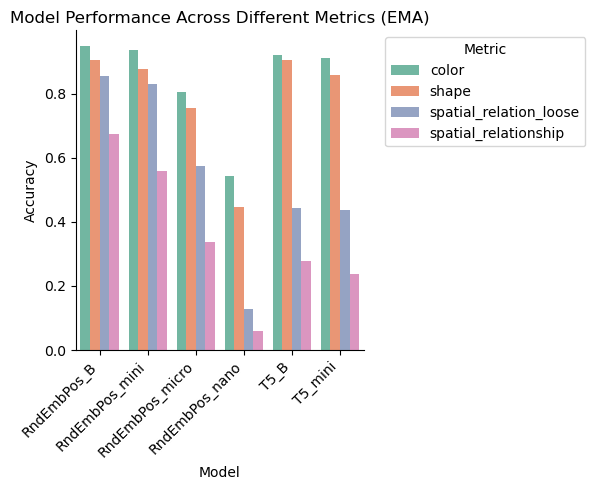

In [71]:
# Create a bar plot of the evaluation results
plt.figure(figsize=(6, 5))

# Prepare data for plotting
plot_data = eval_last_ckpt_summary_agg[
    eval_last_ckpt_summary_agg["ckpt_ver"] == "ema"
]

# Flatten the multi-level columns for easier plotting
plot_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in plot_data.columns]

# Melt the data to long format for seaborn
metrics = ['color', 'shape', 'spatial_relation_loose', 'spatial_relationship']#, 'overall'
mean_cols = [f'{metric}_mean' for metric in metrics]
std_cols = [f'{metric}_std' for metric in metrics]

# Melt mean values
plot_data_long = plot_data.melt(
    id_vars=['model_run_name', 'ckpt_ver'],
    value_vars=mean_cols,
    var_name='metric',
    value_name='accuracy'
)
plot_data_long['metric'] = plot_data_long['metric'].str.replace('_mean', '')

# Add standard deviation data
std_data = plot_data.melt(
    id_vars=['model_run_name', 'ckpt_ver'],
    value_vars=std_cols,
    var_name='metric_std',
    value_name='std'
)
std_data['metric'] = std_data['metric_std'].str.replace('_std', '')

# Merge mean and std
plot_data_final = plot_data_long.merge(
    std_data[['model_run_name', 'ckpt_ver', 'metric', 'std']], 
    on=['model_run_name', 'ckpt_ver', 'metric']
)

# Create the plot
sns.barplot(
    data=plot_data_final,
    order=["objrel_rndembdposemb_DiT_B_pilot", 
            "objrel_rndembdposemb_DiT_mini_pilot", 
            "objrel_rndembdposemb_DiT_micro_pilot", 
            "objrel_rndembdposemb_DiT_nano_pilot", 
            "objrel_T5_DiT_B_pilot", 
            "objrel_T5_DiT_mini_pilot", 
        ],
    x='model_run_name',
    y='accuracy',
    hue='metric',
    palette='Set2'
)
# Shorten the model names for better readability
model_name_mapping = {
    "objrel_rndembdposemb_DiT_B_pilot": "RndEmbPos_B",
    "objrel_rndembdposemb_DiT_mini_pilot": "RndEmbPos_mini",
    "objrel_rndembdposemb_DiT_micro_pilot": "RndEmbPos_micro",
    "objrel_rndembdposemb_DiT_nano_pilot": "RndEmbPos_nano",
    "objrel_T5_DiT_B_pilot": "T5_B",
    "objrel_T5_DiT_mini_pilot": "T5_mini"
}
plt.xticks(range(len(model_name_mapping)), 
           [model_name_mapping[name] for name in ["objrel_rndembdposemb_DiT_B_pilot", 
                                                   "objrel_rndembdposemb_DiT_mini_pilot", 
                                                   "objrel_rndembdposemb_DiT_micro_pilot", 
                                                   "objrel_rndembdposemb_DiT_nano_pilot", 
                                                   "objrel_T5_DiT_B_pilot", 
                                                   "objrel_T5_DiT_mini_pilot"]], 
           rotation=45, ha='right')

plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Performance Across Different Metrics (EMA)')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
saveallforms(synopsis_dir, "all_model_eval_comparison_ema")
plt.show()

In [36]:
synopsis_dir

'/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/model_eval_synopsis'

### Scratch

In [ ]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/*.csv

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_0_red_square_is_above_the_blue_triangle.csv
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_10_red_square_is_to_the_left_of_the_blue_circle.csv
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_11_red_square_is_to_the_right_of_the_blue_circle.csv
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_12_red_square_is_above_and_to_the_left_of_the_blue_circle.csv
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_13_red_sq

In [ ]:
pd.read_csv("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_micro_pilot/large_scale_eval_posthoc/eval_df_all_prompts.csv")

,step_num,sample_id,prompt,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2
0,160000,0,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,160000,1,red square is above the blue triangle,0,False,True,True,False,19.0,-26.0,78.0,52.0,59.0,78.0
2,160000,2,red square is above the blue triangle,0,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN
3,160000,3,red square is above the blue triangle,0,False,True,True,False,-40.0,-61.0,32.0,37.0,72.0,98.0
4,160000,4,red square is above the blue triangle,0,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,160000,95,blue circle is below and to the right of the r...,95,True,True,True,True,79.0,70.0,96.0,109.0,17.0,39.0
9596,160000,96,blue circle is below and to the right of the r...,95,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN
9597,160000,97,blue circle is below and to the right of the r...,95,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN
9598,160000,98,blue circle is below and to the right of the r...,95,True,True,True,True,10.0,43.0,46.0,79.0,36.0,36.0


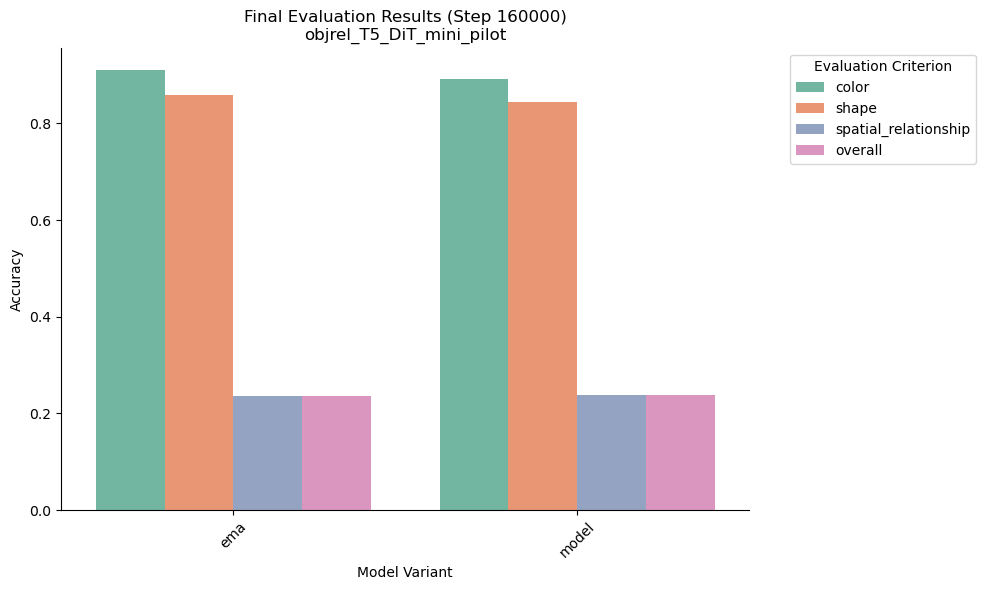

Evaluation results at step 160000:
  ckpt_ver  color_mean  color_std  shape_mean  shape_std  \
0      ema       0.911      0.285       0.859      0.348   
1    model       0.892      0.310       0.843      0.364   

   spatial_relationship_mean  spatial_relationship_std  overall_mean  \
0                      0.237                     0.425         0.237   
1                      0.239                     0.426         0.239   

   overall_std  
0        0.425  
1        0.426  


In [9]:
# Get evaluation results for the last checkpoint across all model variants
last_step = eval_df_all_traj['step_num'].max()
eval_last_ckpt = eval_df_all_traj[eval_df_all_traj['step_num'] == last_step]

# Calculate mean and std accuracy for each checkpoint version and metric
eval_last_summary = eval_last_ckpt.groupby('ckpt_ver')[['color', 'shape', 'spatial_relationship', 'overall']].agg(['mean', 'std']).reset_index()
eval_last_summary.columns = ['ckpt_ver'] + ['_'.join(col).strip() for col in eval_last_summary.columns[1:]]

# Melt the data for plotting
eval_last_long = eval_last_summary.melt(
    id_vars=['ckpt_ver'],
    value_vars=[col for col in eval_last_summary.columns if col.endswith('_mean')],
    var_name='metric',
    value_name='accuracy'
)
eval_last_long['metric'] = eval_last_long['metric'].str.replace('_mean', '')

# Add error columns
eval_last_std = eval_last_summary.melt(
    id_vars=['ckpt_ver'],
    value_vars=[col for col in eval_last_summary.columns if col.endswith('_std')],
    var_name='metric',
    value_name='std'
)
eval_last_std['metric'] = eval_last_std['metric'].str.replace('_std', '')

# Merge mean and std
eval_last_long = eval_last_long.merge(eval_last_std, on=['ckpt_ver', 'metric'])

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=eval_last_long,
    x='ckpt_ver',
    y='accuracy',
    hue='metric',
    palette='Set2',
    errorbar=None  # We'll add custom error bars
)

# # Add error bars manually
# ax = plt.gca()
# for i, container in enumerate(ax.containers):
#     # Get the corresponding std values for this metric
#     metric_name = eval_last_long['metric'].unique()[i]
#     std_values = eval_last_long[eval_last_long['metric'] == metric_name]['std'].values
    
#     # Add error bars
#     ax.errorbar(
#         x=range(len(container)),
#         y=[bar.get_height() for bar in container],
#         yerr=std_values,
#         fmt='none',
#         capsize=3,
#         color='black',
#         alpha=0.7
#     )

plt.xlabel('Model Variant')
plt.ylabel('Accuracy')
plt.title(f'Final Evaluation Results (Step {last_step})\n{model_run_name}')
plt.legend(title='Evaluation Criterion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
# saveallforms(synopsis_dir, f"{model_run_name}_eval_final_comparison")
plt.show()

# Print summary statistics
print(f"Evaluation results at step {last_step}:")
print(eval_last_summary.round(3))
